In [30]:
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import torch
import random
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import EEGModels 
warnings.filterwarnings('ignore')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Num GPUs Available:  3


In [31]:
data_path = './dataset'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
cross = 20

cuda:1


In [32]:
def Validation(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [33]:
class CNN(nn.Module):
    def __init__(self, num_classes = 2):
        super(CNN, self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv1d(in_channels = 5, out_channels = 8, kernel_size = 4, padding = 1),
            nn.MaxPool1d(kernel_size = 4, stride = 1),
            nn.ReLU(),
            nn.Conv1d(in_channels = 8, out_channels = 16, kernel_size = 4),
            nn.Conv1d(in_channels = 16, out_channels = 32, kernel_size = 4, padding = 1),
            nn.ReLU()
        )  
        self.classifier = nn.Sequential(
            nn.Linear(1728, 2048),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2048, num_classes)
        )
    
    def forward(self, x):
        x = self.feature_extraction(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [34]:
data_list = os.listdir(data_path)
acc_tests_CNN = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = torch.from_numpy(traindata[:,:-1]).float(), torch.from_numpy(traindata[:,-1])
        test_data, test_label = torch.from_numpy(testdata[:,:-1]).float(), torch.from_numpy(testdata[:,-1])
        train_data = train_data.reshape(train_data.shape[0], 62, 5).permute(0, 2, 1)
        test_data = test_data.reshape(test_data.shape[0], 62, 5).permute(0, 2, 1)
        train_set = torch.utils.data.TensorDataset(train_data, train_label)
        test_set = torch.utils.data.TensorDataset(test_data, test_label)
        train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=64, shuffle=False, drop_last=False)
        test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=64, shuffle=False, drop_last=False)
        net = CNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=0.0005, betas=(0.9, 0.8))
        epoches = 15
        for epoch in range(epoches): 
            if epoch > 10:
                optimizer = optim.Adam(net.parameters(), lr=0.0001, betas=(0.9, 0.8))
            for i, data in enumerate(train_loader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                optimizer.zero_grad()
                outputs = net(inputs)
                loss = criterion(outputs, labels.long())
                loss.backward()
                optimizer.step()
        tests.append(Validation(net=net, testloader=test_loader))
    acc_test = np.mean(tests)
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_CNN.append(acc_test)

Begin to process person huangsiye_20210529_1.


Acc of train set: 0.89519
Acc of test set: 0.89648
Begin to process person huangsiye_20210531_2.
Acc of train set: 0.91596
Acc of test set: 0.91520
Begin to process person huangsiye_20210604_3.
Acc of train set: 0.87035
Acc of test set: 0.87596
Begin to process person liangjie_20210424_2.
Acc of train set: 0.73481
Acc of test set: 0.73805
Begin to process person liuzhiwei_20210608_1.
Acc of train set: 0.75819
Acc of test set: 0.75006
Begin to process person liuzhiwei_20210611_2.
Acc of train set: 0.81680
Acc of test set: 0.81691
Begin to process person tana_20210425_1.
Acc of train set: 0.92590
Acc of test set: 0.92501
Begin to process person zengcheng_20210615_1.
Acc of train set: 0.77317
Acc of test set: 0.76593
Begin to process person zengjingyao_20210604_2.
Acc of train set: 0.83022
Acc of test set: 0.84593
Begin to process person zhengwenxin_20210415_1.
Acc of train set: 0.80673
Acc of test set: 0.81308
Begin to process person zhengwenxin_20210429_2.
Acc of train set: 0.79442
Acc 

In [ ]:
data_list = os.listdir(data_path)
acc_tests_EEGNet = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = tf.convert_to_tensor(traindata[:,:-1]), tf.convert_to_tensor(traindata[:,-1])
        test_data, test_label = tf.convert_to_tensor(testdata[:,:-1]), tf.convert_to_tensor(testdata[:,-1])
        train_data = tf.reshape(train_data, [train_data.shape[0], 1, 310])
        test_data = tf.reshape(test_data, [test_data.shape[0], 1, 310])
        net = EEGModels.EEGNet_SSVEP(nb_classes=2, Chans=1, Samples=310)
        net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam')
        net.fit(train_data,train_label,batch_size=64,epochs = 15)
        y = net(test_data).numpy()
        y = torch.Tensor(y)
        _, predicted = torch.max(y, 1)
        predicted = predicted.numpy()
        tests.append((predicted==test_label.numpy()).sum().item()/test_label.shape[0])
    acc_test = np.mean(tests)
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_EEGNet.append(acc_test)

In [ ]:
data_list = os.listdir(data_path)
acc_tests_EEGNet2 = []
for path in data_list:
    print("Begin to process person {}.".format(path.split('.')[0]))
    path = os.path.join(data_path, path)
    list_videos = os.listdir(path)
    trains, tests = [], []
    for i in range(cross):
        random.shuffle(list_videos)
        trainset, testset = list_videos[:7], list_videos[7:]
        traindata, testdata = np.load(os.path.join(path, trainset[0])), np.load(os.path.join(path, testset[0]))
        for j in range(1, len(trainset)):
            traindata = np.concatenate((traindata, np.load(os.path.join(path, trainset[j]))), axis=0)
        for j in range(1, len(testset)):
            testdata = np.concatenate((testdata, np.load(os.path.join(path, testset[j]))), axis=0)
        train_data, train_label = tf.convert_to_tensor(traindata[:,:-1]), tf.convert_to_tensor(traindata[:,-1])
        test_data, test_label = tf.convert_to_tensor(testdata[:,:-1]), tf.convert_to_tensor(testdata[:,-1])
        train_data = tf.reshape(train_data, [train_data.shape[0], 62, 5])
        test_data = tf.reshape(test_data, [test_data.shape[0], 62, 5])
        net = EEGModels.EEGNet_SSVEP(nb_classes=2, Chans=62, Samples=5)
        net.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer = 'adam')
        net.fit(train_data,train_label,batch_size=64,epochs = 15)
        y = net(test_data).numpy()
        y = torch.Tensor(y)
        _, predicted = torch.max(y, 1)
        predicted = predicted.numpy()
        tests.append((predicted==test_label.numpy()).sum().item()/test_label.shape[0])
    acc_test = np.mean(tests)
    print("Acc of test set: {:.5f}".format(acc_test))
    acc_tests_EEGNet2.append(acc_test)

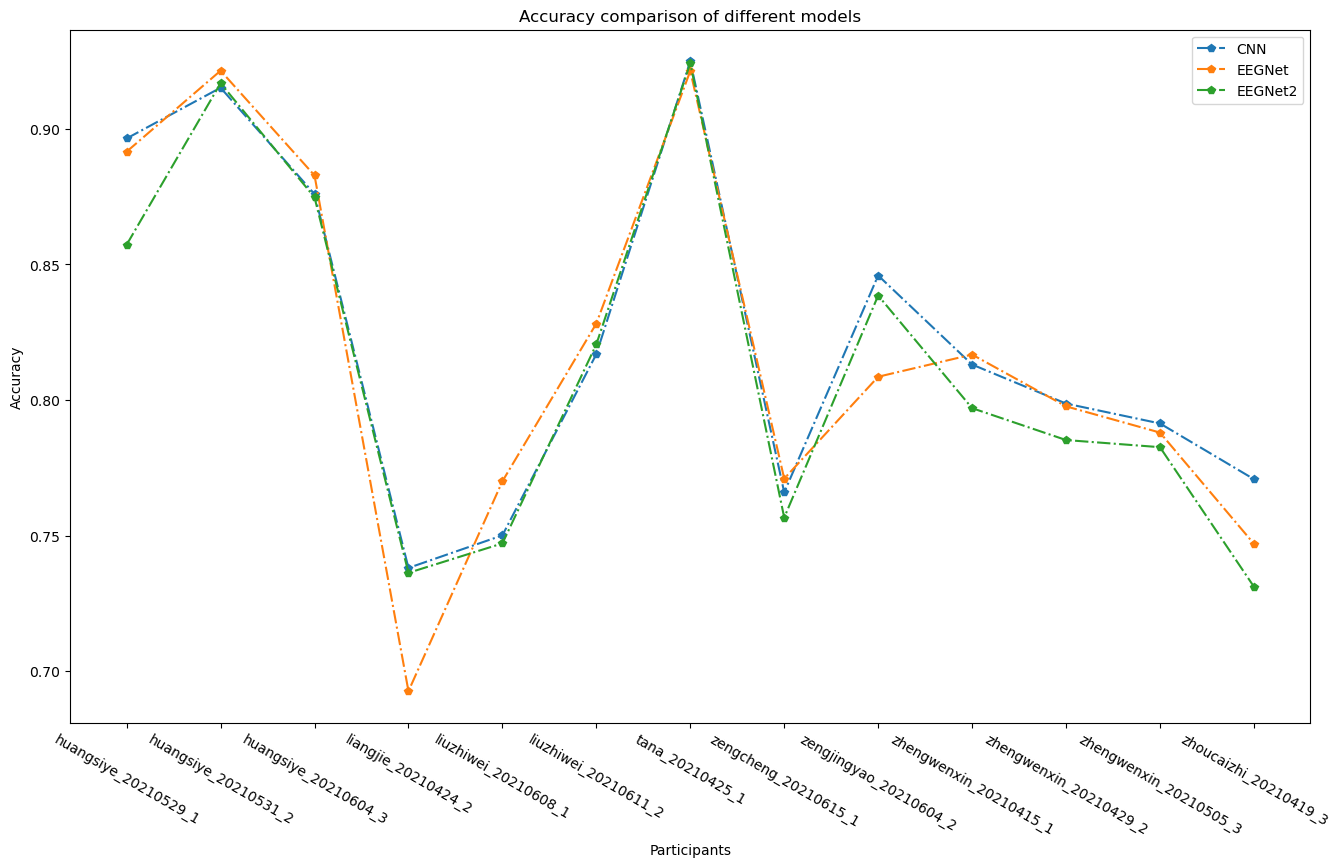

In [37]:
plt.figure(figsize = (16, 9))
plt.xlabel('Participants')
plt.xticks(rotation = -30)
plt.ylabel('Accuracy')
plt.title("Accuracy comparison of different models")
x = os.listdir(data_path)
plt.plot(x, acc_tests_CNN, '-.p')
plt.plot(x, acc_tests_EEGNet, '-.p')
plt.plot(x, acc_tests_EEGNet2, '-.p')
plt.legend(['CNN','EEGNet','EEGNet2'])
plt.show()